## Introduction

This Ultrasound model is the core component of a multi-modal AI system designed for early fetal brain abnormality detection.
It is expert in the analysis of 2D ultrasound images to detect anomalies in critical anatomical structures:

- **CSP (Cavum Septum Pellucidum)**
- **LV (Lateral Ventricles)**

The model employs a pretrained ResNet-based architecture, fine-tuned for binary multi-label classification, and augmented with Grad-CAM for explainability.
The goal is to support clinicians with reliable, readable AI-based diagnostics from non-invasive ultrasound imaging.

## Import Libraries  
This cell loads all the essential Python libraries needed for:  
- Deep learning (`torch`, `torchvision`)  
- Image handling (`PIL`)  
- Visualization (`matplotlib`)  
- Utility tools (`numpy`, `os`, `cv2`)


In [3]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, f1_score
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

## Define Ultrasound Model Architecture
Builds a PyTorch model `UltrasoundResNet` on top of pretrained ResNet18.
This model is customized with:
- An adjusted final fully connected layer for binary classification (Normal vs Abnormal)
- Grad-CAM compatibility for visualizing the activation of class


In [13]:
# Step 2: Define Dataset Loader for Multi-label Ultrasound Image Splits
class UltrasoundDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.image_dir = os.path.join(root_dir, split)
        self.labels_path = os.path.join(root_dir, split, '_classes.csv')
        self.labels_df = pd.read_csv(self.labels_path)
        self.transform = transform

        self.image_paths = []
        supported_exts = ('*.png', '*.jpg', '*.jpeg')
        for ext in supported_exts:
            self.image_paths.extend(glob.glob(os.path.join(self.image_dir, ext)))

        self.image_paths = sorted(self.image_paths)
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {self.image_dir}. Check directory and file formats.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))  # Match pretrained model input size
        image = np.stack([image] * 3, axis=0)  # Convert to 3 channels
        filename = os.path.basename(img_path)

        try:
            row = self.labels_df[self.labels_df['filename'] == filename]
            label = row[['CSP', 'LV']].values.astype(np.float32).squeeze()
        except IndexError:
            raise ValueError(f"Filename '{filename}' not found in {self.labels_path} or missing CSP/LV columns")

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        label = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

## Define Custom Ultrasound Model using Pretrained ResNet18

This cell specifies a custom deep learning model `UltrasoundResNet` to detect **multiple fetal abnormalities** in ultrasound images, i.e.:

- **CSP (Cavum Septum Pellucidum)**
- **LV (Lateral Ventricles)**

Key Highlights:
- **Transfer Learning**: Uses `ResNet18` that has already been pretrained on ImageNet, thus enabling us to leverage powerful feature extractors learned from a massive dataset of images.
- **Custom Classification Head**: Overrides the default fully connected (fc) layer with:
- A dense layer (128 units) + ReLU activation + Dropout (for overcoming overfitting)
- An output layer with **2 values**, scores for CSP and LV abnormalities.
- **Input Compatibility**: Maintains the convolutional shape and input is required in 3-channel format (RGB ultrasound).

The architecture allows for **multi-label classification**, with both abnormalities able to be identified separately in a single forward pass.


In [14]:
# Step 3: Use Pretrained ResNet for Multi-label Classification
class UltrasoundResNet(nn.Module):
    def __init__(self):
        super(UltrasoundResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)  # Output for CSP and LV
        )

    def forward(self, x):
        return self.base_model(x)


## Training Model 

In [15]:
# Step 4: Training Utility

def train_model(model, dataloader, criterion, optimizer, device, epochs=10):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

In [16]:

# Step 5: Execution
if __name__ == '__main__':
    root_path = r'C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound'
    batch_size = 16
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    transform = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

    train_dataset = UltrasoundDataset(root_dir=root_path, split='train', transform=transform)
    val_dataset = UltrasoundDataset(root_dir=root_path, split='valid', transform=transform)
    test_dataset = UltrasoundDataset(root_dir=root_path, split='test', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = UltrasoundResNet()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
train_model(model, train_loader, criterion, optimizer, device, epochs=10)


Epoch 1/10, Loss: 0.5125
Epoch 2/10, Loss: 0.3240
Epoch 3/10, Loss: 0.1907
Epoch 4/10, Loss: 0.1106
Epoch 5/10, Loss: 0.0754
Epoch 6/10, Loss: 0.0660
Epoch 7/10, Loss: 0.0538
Epoch 8/10, Loss: 0.0461
Epoch 9/10, Loss: 0.0485
Epoch 10/10, Loss: 0.0342


## Save the Trained Model

This cell saves the trained weights of the `UltrasoundResNet` model to a file named `ultrasound_resnet_model.pth`.

- Saving the model in `.pth` format allows you to reuse the trained model later

In [18]:
# Save the trained model
torch.save(model.state_dict(), 'ultrasound_resnet_model.pth')
print("Model saved to 'ultrasound_resnet_model.pth'")


Model saved to 'ultrasound_resnet_model.pth'


## Load and Evaluate Trained Ultrasound Model

This portion:

- Loads the pretrained `UltrasoundResNet` model and moves it to the right device (CPU/GPU)
- Places the model in the eval mode to have consistent inference
- Seeks performance over a labeled set for validation using:
  - `Accuracy` and `F1 Score` for each label (CSP & LV)
  - `Sigmoid` activation for the multilabel prediction
  - Threshold at 0.5 to sense presence of abnormality

This makes sure the model works consistently before it's utilized in the fusion process.


In [20]:
# Initialize model and load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UltrasoundResNet().to(device)
model.load_state_dict(torch.load('ultrasound_resnet_model.pth'))
model.eval()

# Evaluate function
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > threshold).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    for i, cls in enumerate(['CSP', 'LV']):
        acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        print(f"{cls} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# Run evaluation
evaluate_model(model, val_loader, device)


C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CSP - Accuracy: 0.8267, F1 Score: 0.8175
LV - Accuracy: 0.8538, F1 Score: 0.7805


## Visualize Grad-CAM Heatmap  
This function generates and displays a heatmap using Grad-CAM.  
The heatmap highlights important regions of the ultrasound image that influence the model's prediction.


In [21]:
def generate_gradcam(model, image_tensor, class_idx):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Hook to capture gradients and activations
    gradients = []
    activations = []

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activations_hook(module, input, output):
        activations.append(output)

    target_layer = model.base_model.layer4[1].conv2
    handle_1 = target_layer.register_forward_hook(save_activations_hook)
    handle_2 = target_layer.register_backward_hook(save_gradients_hook)

    # Forward + backward
    output = model(image_tensor)
    class_score = output[0, class_idx]
    model.zero_grad()
    class_score.backward()

    # Process Grad-CAM
    grads = gradients[0].cpu().detach().numpy()[0]
    acts = activations[0].cpu().detach().numpy()[0]
    weights = grads.mean(axis=(1, 2))
    cam = np.sum(weights[:, None, None] * acts, axis=0)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Overlay
    img_np = image_tensor.cpu().numpy()[0].transpose(1, 2, 0)
    img_np = (img_np * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = 0.4 * heatmap + 0.6 * img_np

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Grad-CAM: CSP" if class_idx == 0 else "Grad-CAM: LV")
    plt.imshow(overlay[:, :, ::-1])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Original Image")
    plt.imshow(img_np[:, :, 0], cmap='gray')
    plt.axis('off')
    plt.show()

    # Clean up
    handle_1.remove()
    handle_2.remove()


C:\Users\kasar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.4].


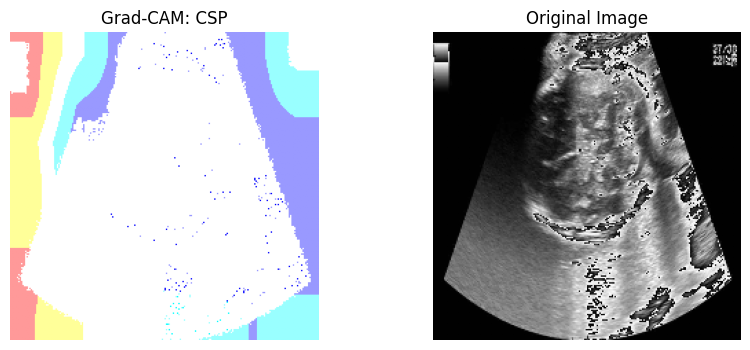

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.4].


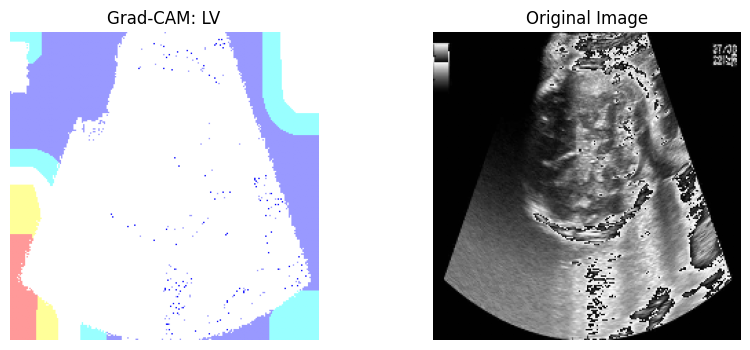

In [22]:
# Visualize first image in validation set for CSP (class 0)
sample_img, _ = val_dataset[0]
generate_gradcam(model, sample_img, class_idx=0)  # CSP
generate_gradcam(model, sample_img, class_idx=1)  # LV


## Perform Inference on Unlabeled Ultrasound Dataset

This block:
- Reads unlabeled images from `Dataset2`
- Uses the trained `UltrasoundResNet` model to predict two abnormality scores:
  - **CSP** (Cavum Septum Pellucidum)
  - **LV** (Lateral Ventricles)
- Prints the results with each filename for easy inspection

Useful for testing the model on new clinical data where there are no labels.


In [23]:
class UltrasoundDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, unlabeled=False):
        self.image_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.unlabeled = unlabeled

        self.image_paths = []
        supported_exts = ('*.png', '*.jpg', '*.jpeg')
        for ext in supported_exts:
            self.image_paths.extend(glob.glob(os.path.join(self.image_dir, ext)))

        self.image_paths = sorted(self.image_paths)
        if len(self.image_paths) == 0:
            raise ValueError(f"No images found in {self.image_dir}.")

        if not unlabeled:
            self.labels_path = os.path.join(root_dir, split, '_classes.csv')
            self.labels_df = pd.read_csv(self.labels_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (224, 224))
        image = np.stack([image] * 3, axis=0)
        image = torch.tensor(image, dtype=torch.float32) / 255.0

        if self.transform:
            image = self.transform(image)

        if self.unlabeled:
            return image, os.path.basename(img_path)
        else:
            filename = os.path.basename(img_path)
            row = self.labels_df[self.labels_df['filename'] == filename]
            label = row[['CSP', 'LV']].values.astype(np.float32).squeeze()
            return image, torch.tensor(label, dtype=torch.float32)


In [24]:
# Load Dataset2 for inference
dataset2 = UltrasoundDataset(root_dir='.', split=r'C:\Users\kasar\Desktop\AI in Healthcare\AI_HEALTHCARE_PROJECT\Ultrasound\Dataset2', transform=transform, unlabeled=True)
dataset2_loader = DataLoader(dataset2, batch_size=1)

# Load trained model
model.load_state_dict(torch.load('ultrasound_resnet_model.pth'))
model.eval()

# Predict on Dataset2
with torch.no_grad():
    for img, fname in dataset2_loader:
        img = img.to(device)
        output = model(img)
        probs = torch.sigmoid(output).cpu().numpy()[0]
        print(f"{fname[0]} => CSP: {probs[0]:.3f}, LV: {probs[1]:.3f}")


000_HC.png => CSP: 0.001, LV: 0.000
001_HC.png => CSP: 0.010, LV: 0.004
002_HC.png => CSP: 0.008, LV: 0.000
003_HC.png => CSP: 0.077, LV: 0.081
004_HC.png => CSP: 0.016, LV: 0.001
005_HC.png => CSP: 0.004, LV: 0.004
006_HC.png => CSP: 0.000, LV: 0.000
007_HC.png => CSP: 0.000, LV: 0.005
008_HC.png => CSP: 0.002, LV: 0.043
009_HC.png => CSP: 0.074, LV: 0.000
010_2HC.png => CSP: 0.000, LV: 0.042
010_HC.png => CSP: 0.000, LV: 0.000
011_HC.png => CSP: 0.000, LV: 0.000
012_HC.png => CSP: 0.167, LV: 0.455
013_HC.png => CSP: 0.143, LV: 0.006
014_2HC.png => CSP: 0.000, LV: 0.000
014_3HC.png => CSP: 0.001, LV: 0.001
014_HC.png => CSP: 0.000, LV: 0.000
015_HC.png => CSP: 0.002, LV: 0.000
016_HC.png => CSP: 0.006, LV: 0.000
017_2HC.png => CSP: 0.002, LV: 0.002
017_HC.png => CSP: 0.000, LV: 0.000
018_HC.png => CSP: 0.003, LV: 0.036
019_2HC.png => CSP: 0.109, LV: 0.060
019_HC.png => CSP: 0.238, LV: 0.057
020_HC.png => CSP: 0.001, LV: 0.002
021_HC.png => CSP: 0.003, LV: 0.659
022_2HC.png => CSP: 0.0

## Predict and Visualize Abnormalities from a Single Ultrasound Image

This part:
- Loads and preprocesses a single image
- Predicts abnormality scores from the trained model
- Classifies as **normal** or **abnormal** by structure (CSP & LV)
- Generates **Grad-CAM overlays** to show image regions that affected each prediction

Perfect for real-time diagnosis and explainable AI visualization.


In [25]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    image = np.stack([image]*3, axis=0)  # convert to 3 channels
    image = torch.tensor(image, dtype=torch.float32) / 255.0
    image = TF.normalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    return image.unsqueeze(0)  # add batch dim

In [26]:

def classify_abnormality(probs, threshold=0.5):
    labels = ["CSP", "LV"]
    report = []
    for i, prob in enumerate(probs):
        if prob > threshold:
            report.append(f"⚠️ {labels[i]} Abnormal (Score: {prob:.2f})")
    if not report:
        report = ["✅ Normal (No CSP or LV abnormality detected)"]
    return report

In [27]:
def generate_gradcam(model, image_tensor, class_idx, device):
    model.eval()
    image_tensor = image_tensor.to(device)

    gradients = []
    activations = []

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activations_hook(module, input, output):
        activations.append(output)

    # hook last conv layer
    target_layer = model.base_model.layer4[1].conv2
    h1 = target_layer.register_forward_hook(save_activations_hook)
    h2 = target_layer.register_backward_hook(save_gradients_hook)

    # forward + backward
    output = model(image_tensor)
    class_score = output[0, class_idx]
    model.zero_grad()
    class_score.backward()

    grads = gradients[0].cpu().detach().numpy()[0]
    acts = activations[0].cpu().detach().numpy()[0]
    weights = grads.mean(axis=(1, 2))
    cam = np.sum(weights[:, None, None] * acts, axis=0)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    # Original image (convert back for overlay)
    orig_img = image_tensor.cpu().numpy()[0].transpose(1, 2, 0)
    orig_img = ((orig_img * 0.5 + 0.5) * 255).astype(np.uint8)

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_img, 0.5, heatmap, 0.5, 0)

    # Clean up
    h1.remove()
    h2.remove()

    return overlay

In [28]:
def predict_and_visualize(image_path, model, device, threshold=0.5):
    print(f"\n📷 Analyzing: {image_path}")
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor.to(device))
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    results = classify_abnormality(probs, threshold=threshold)
    print("\n🧾 Diagnosis Report:")
    for r in results:
        print("  ", r)

    # Grad-CAM for each class
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    for idx, label in enumerate(["CSP", "LV"]):
        cam_overlay = generate_gradcam(model, image_tensor.clone(), class_idx=idx, device=device)
        axs[idx].imshow(cam_overlay[:, :, ::-1])
        axs[idx].set_title(f"{label} - Grad-CAM")
        axs[idx].axis('off')
    plt.tight_layout()
    plt.show()



📷 Analyzing: Dataset2/803_HC.png

🧾 Diagnosis Report:
   ⚠️ CSP Abnormal (Score: 0.84)


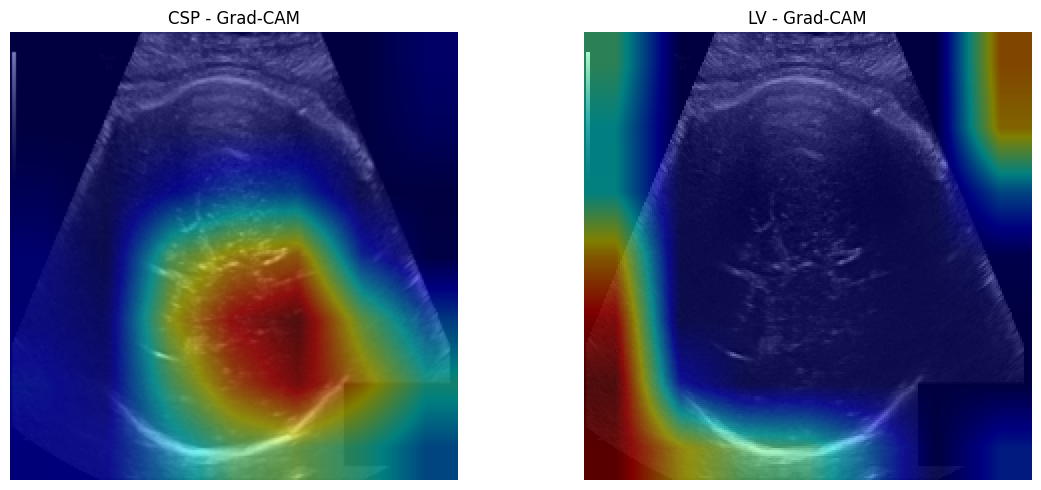

In [29]:
model.load_state_dict(torch.load("ultrasound_resnet_model.pth"))
predict_and_visualize("Dataset2/803_HC.png", model, device)


### Evaluate Model Metrics CSP & LV

In [30]:
def evaluate_metrics(model, dataloader, device, threshold=0.5):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > threshold).astype(int)

            all_preds.append(preds)
            all_probs.append(probs)
            all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_probs = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)

    class_names = ["CSP", "LV"]
    print("📊 Evaluation Metrics:\n")

    for i, name in enumerate(class_names):
        acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        prec = precision_score(all_labels[:, i], all_preds[:, i])
        rec = recall_score(all_labels[:, i], all_preds[:, i])
        f1 = f1_score(all_labels[:, i], all_preds[:, i])
        try:
            auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
        except ValueError:
            auc = np.nan

        print(f"🧠 {name}:\n  Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUROC: {auc:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
        plt.figure(figsize=(3.5, 3.5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


📊 Evaluation Metrics:

🧠 CSP:
  Accuracy: 0.8267 | Precision: 0.8498 | Recall: 0.7875 | F1: 0.8175 | AUROC: 0.9109


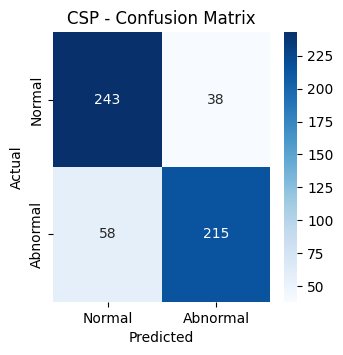

🧠 LV:
  Accuracy: 0.8538 | Precision: 0.8521 | Recall: 0.7200 | F1: 0.7805 | AUROC: 0.9190


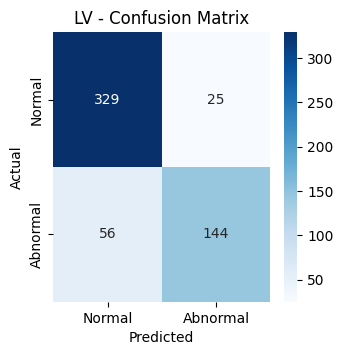

In [31]:
model.load_state_dict(torch.load("ultrasound_resnet_model.pth"))
evaluate_metrics(model, val_loader, device)
